In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib


#change the default matplotlib font to CMU Serif
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['CMU Serif']

In [16]:
map_df = gpd.read_file(f"./croatia.shp")

In [17]:
import difflib

def vote_import(excel_file, party_name):
    #import vote data from excel
    votes = pd.read_excel(excel_file)

    # create a new dataframe only with the votes[votes.keys()[5]] and votes.keys()[i] for i in range(15, len(votes.keys()), 15)

    votes_df = pd.DataFrame()
    votes_df[votes.keys()[5]] = votes[votes.keys()[5]]
    for i in range(15, len(votes.keys()), 15):
        votes_df[votes.keys()[i]] = votes[votes.keys()[i]]
    #merge all entries with the same entry in votes_df["Grad/općina/država"] by adding up all the numbers in other columns
    votes_df = votes_df.groupby(votes_df[votes.keys()[5]]).sum()
    votes_df = votes_df.reset_index()
    #print the data frame as a nice table

    
    if party_name == "None":
        votes_df["winner_percentage"] = votes_df[votes_df.keys()[1:]].max(axis=1) / votes_df[votes_df.keys()[1:]].sum(axis=1)
        
        max_no = votes_df[votes_df.keys()[1:]].idxmax(axis=1)
        votes_no = votes_df[votes_df.keys()[1:]].sum(axis=1)
        
        votes_df["winner"] = max_no
        city_winner = pd.DataFrame()
        city_winner["City"] = votes_df[votes_df.keys()[0]]
        city_winner["winner"] = votes_df["winner"]
        city_winner["winner_percentage"] = votes_df["winner_percentage"]
        city_winner["total votes"] = votes_no
        return city_winner
    
    else:
        for i in votes_df.keys()[1:]:
            if party_name in i:
                votes_df["winner_percentage"] = votes_df[i] / votes_df[votes_df.keys()[1:]].sum(axis=1)
                votes_df["winner"] = i
                city_winner = pd.DataFrame()
                city_winner["City"] = votes_df[votes_df.keys()[0]]
                city_winner["winner"] = votes_df["winner"]
                city_winner["winner_percentage"] = votes_df["winner_percentage"]
                city_winner["no of votes"] = votes_df[i]

                return city_winner
        

In [18]:
def data_import_and_process(party_name):
    for i in range(1, 11):
        
        if i < 10: 
            city_winner = vote_import(f"./2024/Results/02_0{str(i)}.xlsx", party_name)
        else:
            city_winner = vote_import(f"./2024/Results/02_{str(i)}.xlsx", party_name)
        # combine the city_winner dataframes
        if i == 1:
            all_city_winner = city_winner
        else:
            all_city_winner = pd.concat([all_city_winner, city_winner])
    
    #reset the index
    all_city_winner = all_city_winner.reset_index()
    #remove the old index
    all_city_winner = all_city_winner.drop(columns=["index"])

    #turn the dataframe into a dictionary
    all_city_winner_dict = all_city_winner.T.to_numpy()

    #turn all all_city_winner_dict[0] lowerdase apart from the first letter
    for i in range(len(all_city_winner_dict[0])):
        all_city_winner_dict[0][i] = all_city_winner_dict[0][i].capitalize()
        
    # from each city name remove everything after " - " unless "Zagreb" is in the name

    for i in range(len(all_city_winner_dict[0])):
        if "Zagreb" not in all_city_winner_dict[0][i]:
            all_city_winner_dict[0][i] = all_city_winner_dict[0][i].split(" - ")[0]
            
            
    HDZ_votes = 0
    total_Zagreb_votes = 0
    party_votes = 0


    if party_name == "None":

        for i in range(len(all_city_winner_dict[0])):
            if "Zagreb" in all_city_winner_dict[0][i]:
                total_Zagreb_votes += all_city_winner_dict[3][i]
                if "HDZ" in all_city_winner_dict[1][i]:
                    HDZ_votes += all_city_winner_dict[2][i]*all_city_winner_dict[3][i]


        #append Zagreb to the list of cities
        for i in range(len(all_city_winner_dict[0])):
            if "Zagreb" in all_city_winner_dict[0][i]:
                all_city_winner_dict[0][i] = "Zagreb"
                all_city_winner_dict[1][i] = "HDZ"
                all_city_winner_dict[2][i] = HDZ_votes / total_Zagreb_votes
                all_city_winner_dict[3][i] = total_Zagreb_votes
                
    else:
        for i in range(len(all_city_winner_dict[0])):
            if "Zagreb" in all_city_winner_dict[0][i]:
                total_Zagreb_votes += all_city_winner_dict[3][i]
                party_votes += all_city_winner_dict[2][i]*all_city_winner_dict[3][i]
        
        #append Zagreb to the list of cities
        for i in range(len(all_city_winner_dict[0])):
            if "Zagreb" in all_city_winner_dict[0][i]:
                all_city_winner_dict[0][i] = "Zagreb"
                all_city_winner_dict[1][i] = party_name
                all_city_winner_dict[2][i] = party_votes / total_Zagreb_votes
                all_city_winner_dict[3][i] = total_Zagreb_votes
            
    return all_city_winner_dict


In [19]:
def map_plot(party_name, all_city_winner_dict):

    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax = map_df.plot(ax=ax)
    map_df.plot(ax=ax, color="white")
    
    ax.set_axis_off()

    for name, party, percentage in zip(all_city_winner_dict[0], all_city_winner_dict[1], all_city_winner_dict[2]):  
        # replace č, ć, ž, š, đ with ?
        name = name.replace("č", "?").replace("ć", "?").replace("ž", "?").replace("š", "?").replace("đ", "?")
        # also the capital letters
        name = name.replace("Č", "?").replace("Ć", "?").replace("Ž", "?").replace("Š", "?").replace("Đ", "?")
        
        #missing city name replacements
        map_df["name_2"] = map_df["name_2"].replace("Stari Grad", "Stari grad")
        map_df["name_2"] = map_df["name_2"].replace("Blaca", "Solin")
        map_df["name_2"] = map_df["name_2"].replace("Lopar/Supetarska Draga", "Rab")
        map_df["name_2"] = map_df["name_2"].replace("Premantura", "Medulin")
        map_df["name_2"] = map_df["name_2"].replace("Unije", "Cres")
        map_df["name_2"] = map_df["name_2"].replace("Susak", "Mali Lo?inj")
        map_df["name_2"] = map_df["name_2"].replace("Ilovik", "Mali Lo?inj")
        map_df["name_2"] = map_df["name_2"].replace("Vele Srakane", "Mali Lo?inj")
        map_df["name_2"] = map_df["name_2"].replace("Male Srakane", "Mali Lo?inj")
        map_df["name_2"] = map_df["name_2"].replace("Unknown_1", "Bukovlje")
        map_df["name_2"] = map_df["name_2"].replace("Unknown_2", "Ernestinovo")
        map_df["name_2"] = map_df["name_2"].replace("Unknown_3", "Bilje")
        map_df["name_2"] = map_df["name_2"].replace("Donji Martijanec", "Martijanec")
        map_df["name_2"] = map_df["name_2"].replace("Sveta Marija na Muri", "Sveta marija")
        map_df["name_2"] = map_df["name_2"].replace("Osjecko-Baranjska", "?odolovci")
        map_df["name_2"] = map_df["name_2"].replace("Njivice", "Omi?alj")
        
        matches = difflib.get_close_matches(name, map_df["name_2"])
        
        #Mozemo cmap
        mozemo_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","#c4d844","#383e13"])
        
        if len(matches) > 0:
            # color based on the percentage of votes using a colormap
            if "HDZ" in party:
                map_df[map_df["name_2"] == matches[0]].plot(ax=ax, color=plt.cm.Blues(percentage))
            elif "SDP" in party:
                map_df[map_df["name_2"] == matches[0]].plot(ax=ax, color=plt.cm.Reds(percentage))
            elif "MOST" in party:
                map_df[map_df["name_2"] == matches[0]].plot(ax=ax, color=plt.cm.Oranges(percentage))
            elif "DP" in party:
                map_df[map_df["name_2"] == matches[0]].plot(ax=ax, color=plt.cm.Greys(percentage))
            elif "MOŽEMO!" in party:
                map_df[map_df["name_2"] == matches[0]].plot(ax=ax, color=mozemo_cmap(percentage))
            elif "IDS" in party:
                map_df[map_df["name_2"] == matches[0]].plot(ax=ax, color=plt.cm.Greens(percentage))
            elif "NPS" in party:
                map_df[map_df["name_2"] == matches[0]].plot(ax=ax, color=plt.cm.Purples(percentage))   
            elif "VIKTOR ŠIMUNIĆ" in party:
                map_df[map_df["name_2"] == matches[0]].plot(ax=ax, color=plt.cm.RdPu(percentage))
                


    if party_name == "None":
        map_df.boundary.plot(ax=ax, linewidth=0.1, color="black")
        # create an inset for the colorbar
        cbaxes = inset_axes(ax, width="15%", height="1.25%", loc=3, bbox_to_anchor=(50, 30, 600, 550))
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cbaxes, orientation='horizontal')
        cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
        cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
        # set label font size to 7
        cbar.ax.tick_params(labelsize=7)


        # put text on the graph
        plt.text(1.03, 0, "HDZ", fontsize=7)

        party_names = ["SDP", "Most", "DP", "IDS", "NL – Viktor Šimunić", "NPS", "Možemo!"]
        color_maps = [plt.cm.Reds, plt.cm.Oranges, plt.cm.Greys, plt.cm.Greens, plt.cm.RdPu, plt.cm.Purples, mozemo_cmap]

        for party_name, color_map, height in zip(party_names, color_maps, range(1, len(party_names)+1)):
            cbaxes = inset_axes(ax, width="15%", height="1.25%", loc=3, bbox_to_anchor=(50, 30 + 10*height, 600, 550))
            sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=0, vmax=1))
            sm._A = []
            cbar = plt.colorbar(sm, cax=cbaxes, orientation='horizontal')
            cbar.set_ticks([])
            cbar.set_ticklabels([])
            plt.text(1.03, 0.03, party_name, fontsize=7)
            
        plt.savefig(f"./2024/Maps/SVG/map_full.svg", dpi=round(fig.dpi/2))
        plt.savefig(f"./2024/Maps/PNG/map_full.png", dpi=fig.dpi)

    else:        
        party_names = ["HDZ", "SDP", "MOST", "DP", "IDS", "NPS", "MOŽEMO!"]
        color_maps = [plt.cm.Blues, plt.cm.Reds, plt.cm.Oranges, plt.cm.Greys, plt.cm.Greens, plt.cm.Purples, mozemo_cmap]
        
        color_map = color_maps[party_names.index(party_name)]
        
        cbaxes = inset_axes(ax, width="30%", height="2%", loc=3, bbox_to_anchor=(50, 50, 600, 550))
        sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cbaxes, orientation='horizontal')
        cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
        cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
        
        map_df.boundary.plot(ax=ax, linewidth=0.1, color="black")
        # make empty regions white
        
        
        plt.text(1.03, 0, party_name, fontsize=12)
        
        # save the map as a png file
        plt.savefig(f"./2024/Maps/PNG/map_{party_name}.png", dpi=fig.dpi)
        plt.savefig(f"./2024/Maps/SVG/map_{party_name}.svg", dpi=round(fig.dpi/2))

    plt.show()



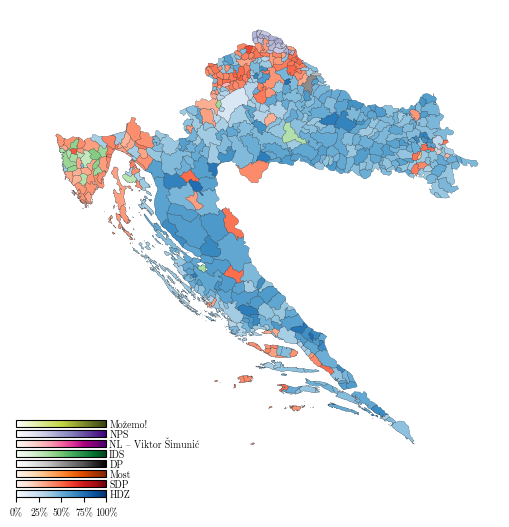

In [20]:
party_name = "None"

all_city_winner_dict = data_import_and_process(party_name)

map_plot(party_name, all_city_winner_dict)

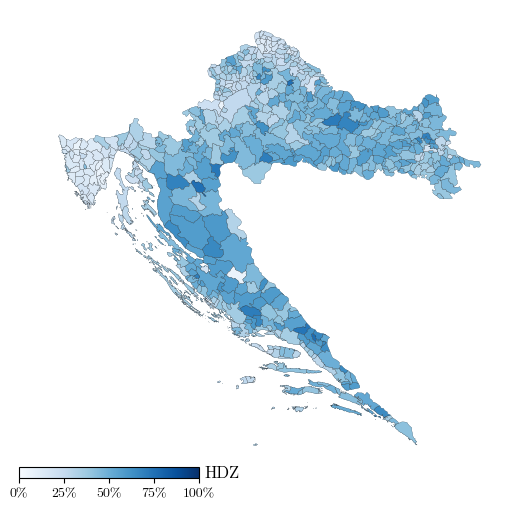

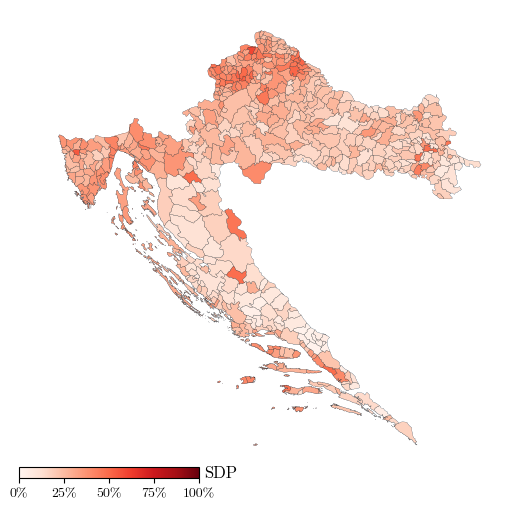

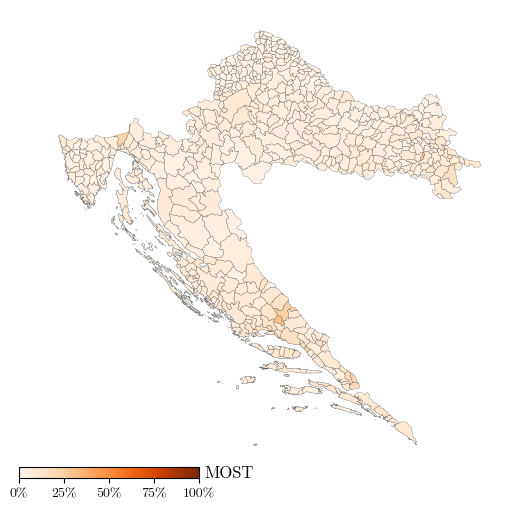

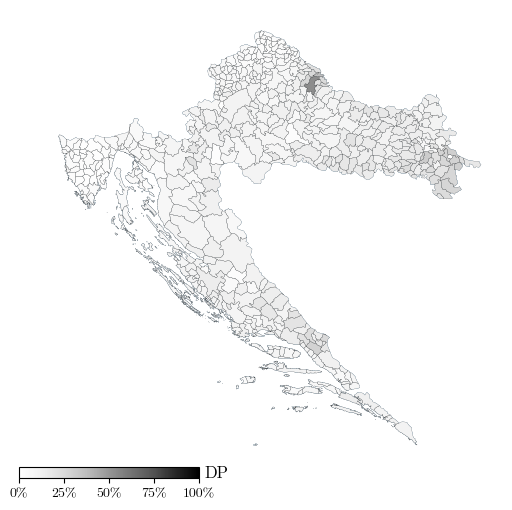

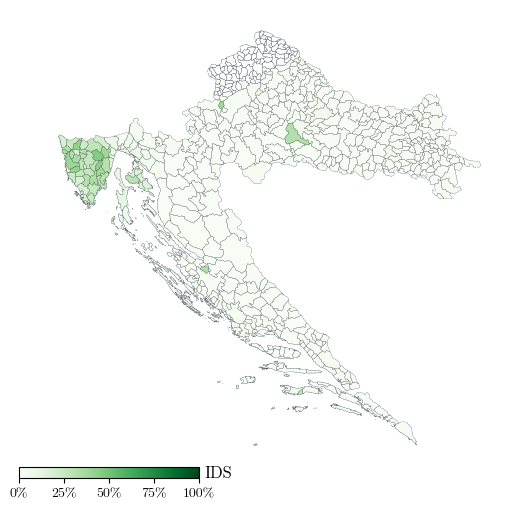

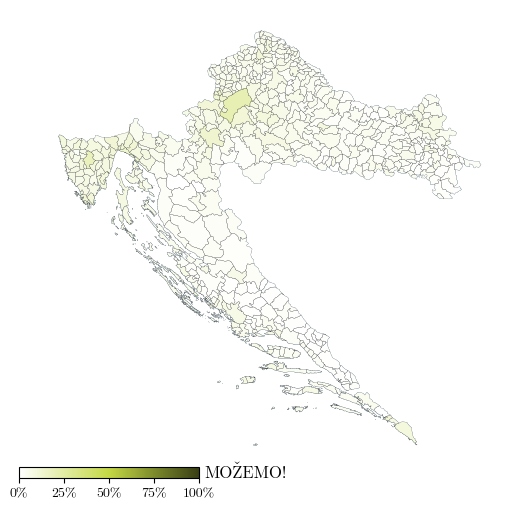

In [21]:
party_names = ["HDZ", "SDP", "MOST", "DP", "IDS", "MOŽEMO!"]

for i in party_names:
    all_city_winner_dict = data_import_and_process(i)
    map_plot(i, all_city_winner_dict)